## Estimating statistical errror bars with Jackknife resampling

This example shows how to extract the second Renyi entropy $S_2=\mathrm{Tr}(\rho^2)$ and the associated error bars.

In [9]:
using RandomMeas

First we load in memory a random quantum state and calculates the purities accross different cuts

In [10]:
N  = 6 #number of qubits
χ = 2^(N÷2) #a large bond-dimension to consider a typical random state
ξ = siteinds("Qubit", N)
ψ = random_mps(ξ; linkdims=χ);

S = [-log2(get_trace_moment(ψ,2,collect(1:NA))) for NA in 1:N] 
println("Entropies ", S);

Entropies [0.7491570759118782, 1.2299098955598111, 1.5601311737287922, 1.4936048647541356, 0.9754273440576239, 6.406853007629837e-16]


Then we sample randomized measurements 

In [11]:
using ProgressMeter

ITensors.disable_warn_order()
NU = 400
NM = 400
measurement_group = MeasurementGroup(ψ,NU,NM;mode="dense");

[Jackknife resampling](https://en.wikipedia.org/wiki/Jackknife_resampling) provides a simple method to estimate statistical errors when estimating a physical quantity from a single dataset. The helper function below returns the Jackknife estimation of the statistical error for an estimator evaluated on a vector of $n_s$ samples. The function provides also an approximate unbiased evaluation of the estimator. 

In [12]:
using Statistics

function jackknife(estimator::Function,samples::Vector)
    ns = length(samples)
    θ = zeros(Float64,ns)
    for i in 1:ns
        θ[i] = estimator(samples[1:end .!= i])
    end
    θ_est = ns*estimator(samples)-(ns-1)*mean(θ) #approximate unbiased estimator
    var_est = var(θ)* (ns - 1)^2 / ns #approximate statistical variance 
    return θ_est, sqrt(var_est)
end

jackknife (generic function with 1 method)

We can then apply this method for a purity estimation based on batch shadows [Rath et al, PRX quantum 2023](https://doi.org/10.1103/PRXQuantum.4.010318).
Note that Jacknife methods requires evaluating the estimator $n_s$ times, so we use here a small number $n_s=40$ of batch shadows to obtain a result in a reasonable time.

In [13]:
number_of_ru_batches = 40 #number of batches
S_est = zeros(Float64,N)
σ= zeros(Float64,N)
@showprogress dt=1 for NA in 1:N

    reduced_measurement_group = reduce_to_subsystem(measurement_group,collect(1:NA))
    
    ρs = get_dense_shadows(reduced_measurement_group,number_of_ru_batches=number_of_ru_batches);

    estimator(x) = -log2(get_trace_moment(x, 2))

    S_est[NA], σ[NA] = jackknife(estimator,ρs)
end   

Progress: 100%|█████████████████████████████████████████| Time: 0:00:53


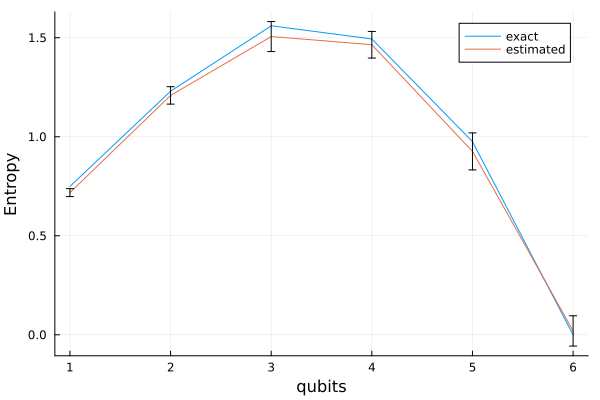

In [14]:
using Plots
plot(1:N,S,label="exact")
plot!(1:N,S_est,yerr = σ,label="estimated")

ylabel!("Entropy")
xlabel!("qubits")